# Problema de clustering

## Segmentación de clientes de un distribuidor de venta al por mayor

### Descripción del problema:
El objetivo del problema es separar los clientes de un distribuidor al por mayor en grupos lo más homogéneos posibles pero que se diferencien entre ellos lo máximo posible de cara a realizar acciones dirigidas distintas para cada uno de los grupos.

Haremos uso del dataset Wholesale customers. Este dataset se puede descargar de la siguiente ruta de la University of California Irvine (Url: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)

#### Descripción del dataset:
El dataset cuenta con 8 variables descriptivas X.

El número total de muestras es de 440 clientes.

Variables independientes X:

* FRESH: gasto anual (u.m.) en productos frescos (Continuo);
* MILK: gasto anual (u.m.) en productos lácteos (Continuo);
* GROCERY: gasto anual (u.m.) en productos comestibles (Continuo);
* FROZEN: gasto anual (u.m.) en productos congelados (Continuo)
* DETERGENTS_PAPER: gasto anual (u.m.) en detergentes y productos de papel (Continuo)
* DELICATESSEN: gasto anual (u.m.) en productos delicatessen (Continuo);
* CHANNEL: Canal de clientes - Horeca (Hotel / Restaurante / Café) o Canal minorista (Nominal)
* REGION: Región de clientes - Lisnon, Oporto u Otros (Nominal)

## Carga de librerías:

In [3]:
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import boxcox, probplot, norm, shapiro
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
import os
import warnings
warnings.filterwarnings('ignore')

## Definición de funciones:

In [22]:
def comprueba_normalidad(df, return_type='axes', title='Comprobación de normalidad'):
    '''
    '''
    fig_tot = (len(df.columns))
    fig_por_fila = 3
    tamanio_fig = 4
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+2 ) )
    c = 0 
    shapiro_test = {}
    lambdas = {}
    for i, col in enumerate(df.columns):
        ax = plt.subplot(num_filas, fig_por_fila, i+1)
        probplot(x = df[df.columns[i]], dist=norm, plot=ax)
        plt.title(df.columns[i])
        shapiro_test[df.columns[i]] = shapiro(df[df.columns[i]])
    plt.suptitle(title)
    plt.show()
    shapiro_test = pd.DataFrame(shapiro_test, index=['Test Statistic', 'p-value']).transpose()
    return shapiro_test

## Lectura de datos:

In [6]:
X = pd.read_csv(r"C:\Users\Playtomic\Documents\imf\modulo 4 (Machine Learning)\Ejercicio practico de clustering (k-means)\Wholesale customers data.csv")
print(u'- El número de filas en el dataset es: {}', X.shape[0])
print(u'- El número de columnas en el dataset es: {}', X.shape[1])
print(u'- Nombres de las variables: {}', list(X.columns))
X[:2]

- El número de filas en el dataset es: {} 440
- El número de columnas en el dataset es: {} 8
- Nombres de las variables: {} ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776


### Primero pasamos el canal y la región a valores entendibles:

In [7]:
X['Channel'].value_counts()

Channel
1    298
2    142
Name: count, dtype: int64

In [8]:
X['Region'].value_counts()

Region
3    316
1     77
2     47
Name: count, dtype: int64

In [9]:
# Mapeo los datos
X['Channel'] = X['Channel'].map({1:'Horeca', 2:'Retail'})
X['Region'] = X['Region'].map({3:'Other Region', 2:'Oporto', 1: 'Lisboa'})

In [10]:
X[:2]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,Retail,Other Region,12669,9656,7561,214,2674,1338
1,Retail,Other Region,7057,9810,9568,1762,3293,1776


## Preprocesamiento de datos

## Missings:

In [11]:
X.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

## Visualizaciones y correlaciones

### Descriptivos básicos:

In [12]:
X.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Guardo en una variable __X_cuants__ sólo las variables numéricas, ya que voy a representarlas y aplicar alguna transformación sobre ellas.

In [73]:
X_cuants = X[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']].copy()

### Boxplots:

Debemos normalizar los datos primero para que tengan la misma escala y no tener probelmas con la visualizacion de los boxplots

In [74]:
X_normalizado = (X_cuants - X_cuants.mean()) / X_cuants.std()
X_normalizado[:2]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052873,0.522972,-0.041068,-0.588697,-0.043519,-0.066264
1,-0.390857,0.543839,0.170125,-0.269829,0.086309,0.089050


Text(0.5, 0, 'Nombre de la variable')

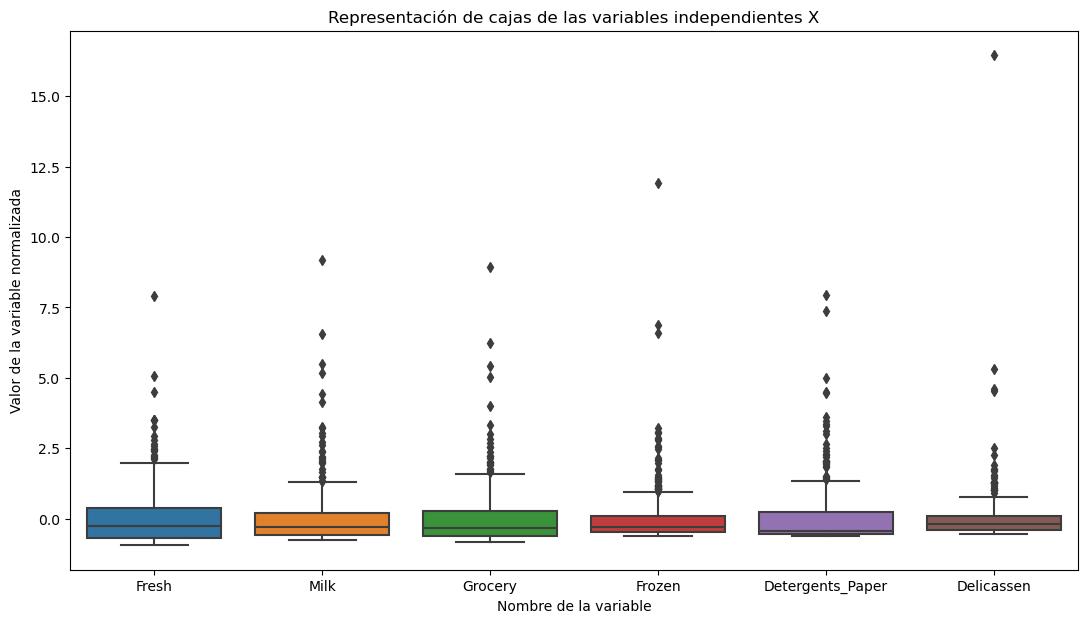

In [75]:
plt.figure(figsize=(13,7))
sns.boxplot(X_normalizado)
plt.xticks(rotation=0)
plt.title('Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
plt.xlabel('Nombre de la variable')

or lo que vemos en las representaciones de cajas todas las variables tienen algún outlier.

### Histogramas:

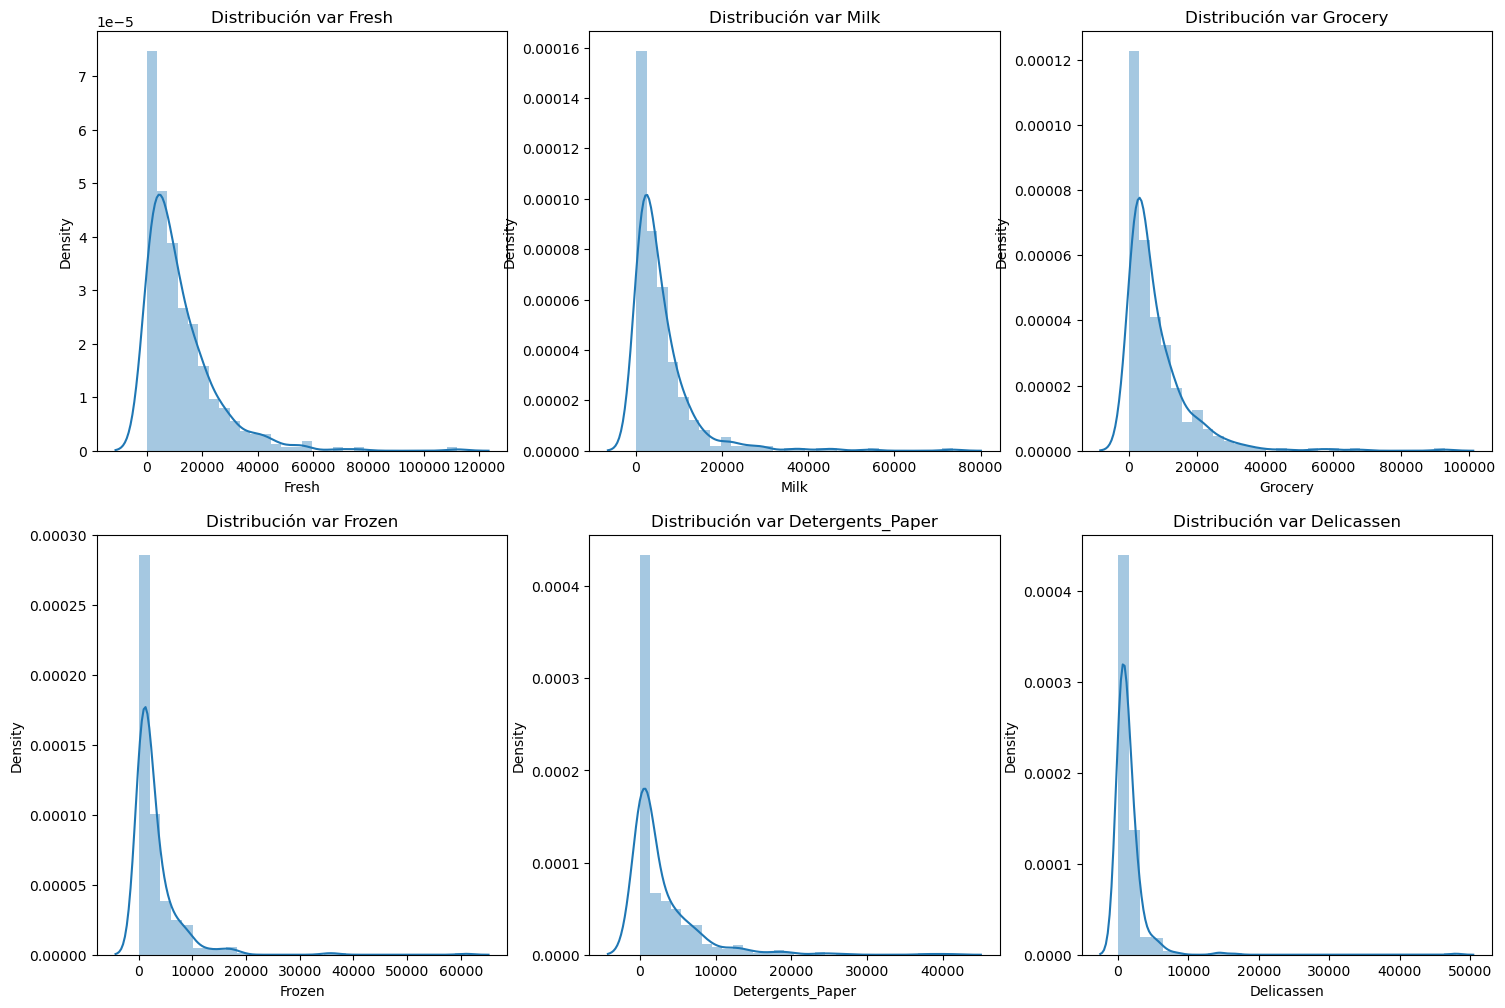

In [76]:
plt.figure(figsize=(18,12))
n = 0
for i, column in enumerate(X_cuants.columns):
    n+=1
    plt.subplot(2, 3, n)
    sns.distplot(X_cuants[column], bins=30)
    plt.title('Distribución var {}'.format(column))

Las variables no siguen distribuciones normales o Gaussianas

### Matriz de correlaciones:

Text(0.5, 1.0, 'Matriz de correlaciones de Pearson')

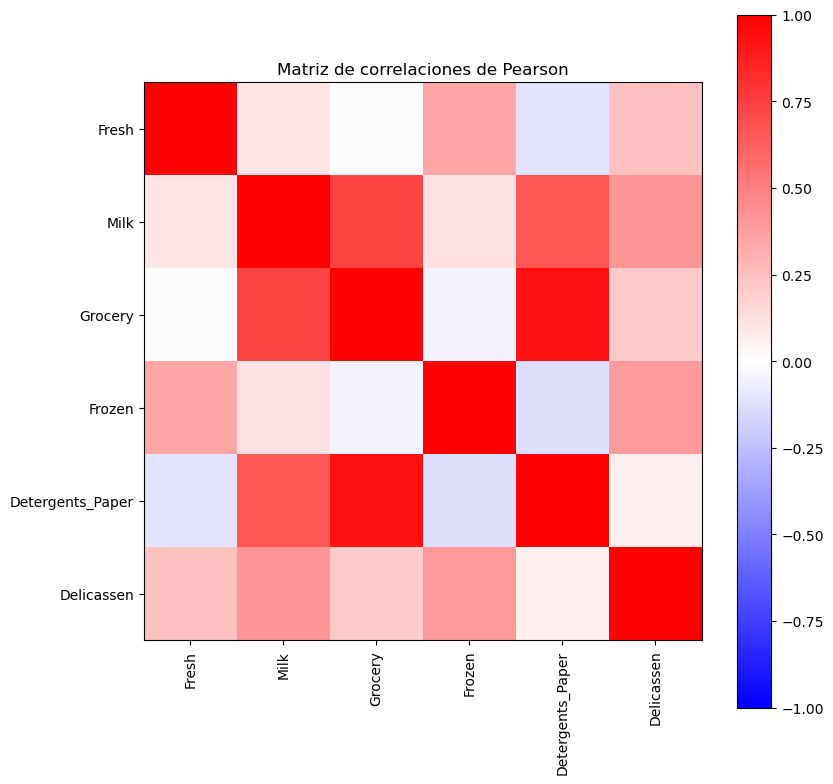

In [77]:
matriz_correlaciones = X_cuants.corr(method='pearson')
n_ticks = len(X_cuants.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), X_cuants.columns, rotation='vertical')
plt.yticks(range(n_ticks), X_cuants.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap='bwr'))
plt.title('Matriz de correlaciones de Pearson')

Ninguna variable está extremadamente correlacionada con otra por lo tanto no será necesario eleiminar variables para evitar problemas de multicolinealidad

## Transformación de datos para cumplir las hipótesis:

Como posteriormente vamos a aplicar un algoritmo K-means, los datos deben cumplir una serie de hipótesis.

- El K-means supone que los datos tienen una distribución normal.
- Además, es muy propenso a outliers.

Por lo tanto, debemos transformar las variables para que sigan una distribución normal y tratar los outliers.

### Normalización de los datos:
La normalización de las variables es el proceso en el que se transforma una variable para que siga una distribución normal o Gaussiana.


Entre las formas de transformar una variable a normal se encuentran métodos como la transformación __Box-Cox__

En las siguientes gráficas se representa el Q-Q Plot, que es un gráfico que compara entre dos distribuciones. En este caso, cada una de las variables con una distribución normal. Si siguen la misma distribución, los puntos caen cerca de la línea roja.

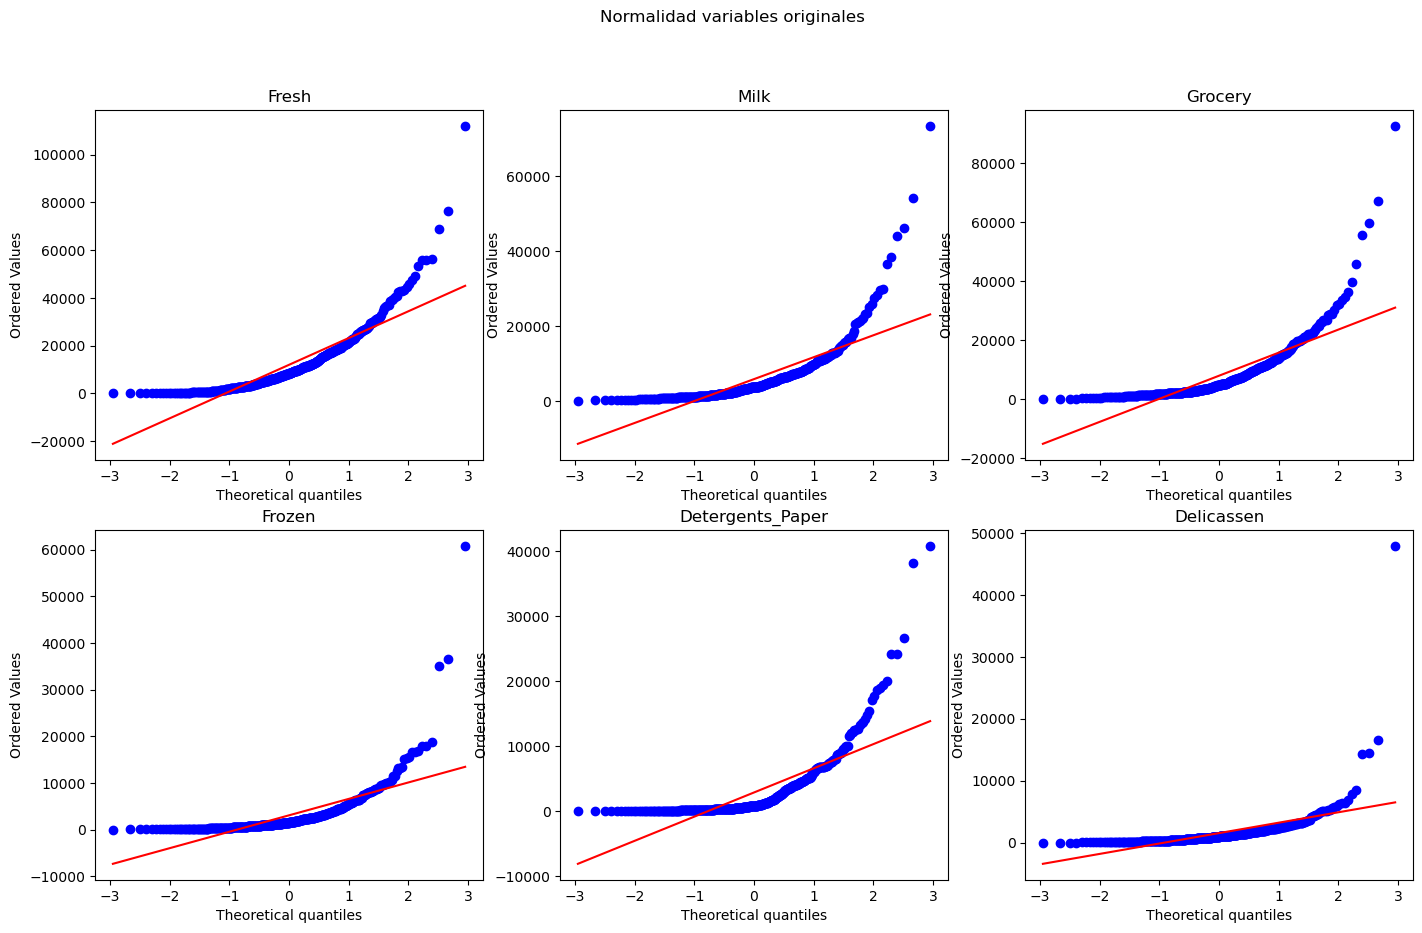

In [78]:
shapiro_test = comprueba_normalidad(X_cuants, title='Normalidad variables originales')

In [79]:
shapiro_test

,Test Statistic,p-value
Fresh,0.781436,7.918438e-24
Milk,0.628334,9.762062e-30
Grocery,0.676230,3.906127e-28
Frozen,0.528297,1.291332e-32
Detergents_Paper,0.605482,1.914593e-30
Delicassen,0.361068,1.753408e-36


El pvalor de todas las variables es menor que 0.05 por lo tanto rechazamos la hipotesis nula del shapiro test que nos dice que las distribuciones de las variables son gaussianas o normales

Ahora transformo las variables con una transformación Box-Cox.

In [80]:
bc = PowerTransformer(method='box-cox')
X_cuants_boxcox = bc.fit_transform(X_cuants)
X_cuants_boxcox = pd.DataFrame(X_cuants_boxcox, columns=X_cuants.columns)

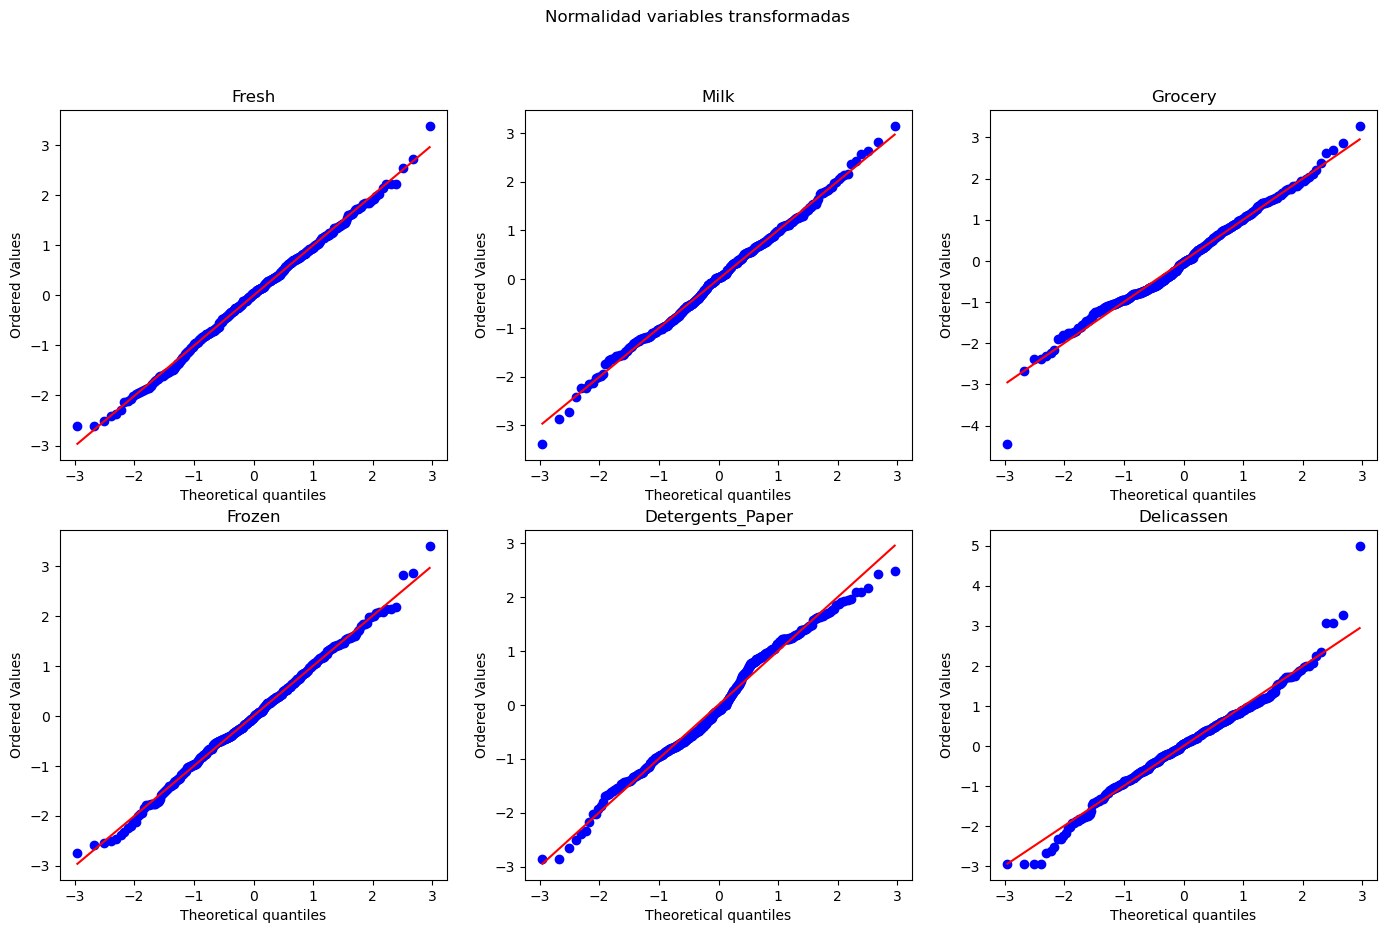

In [81]:
shapiro_test = comprueba_normalidad(X_cuants_boxcox, title='Normalidad variables transformadas')

In [82]:
shapiro_test

,Test Statistic,p-value
Fresh,0.997444,0.737599
Milk,0.996949,0.584208
Grocery,0.989161,0.002424
Frozen,0.997237,0.673512
Detergents_Paper,0.985208,0.000185
Delicassen,0.981869,0.000026


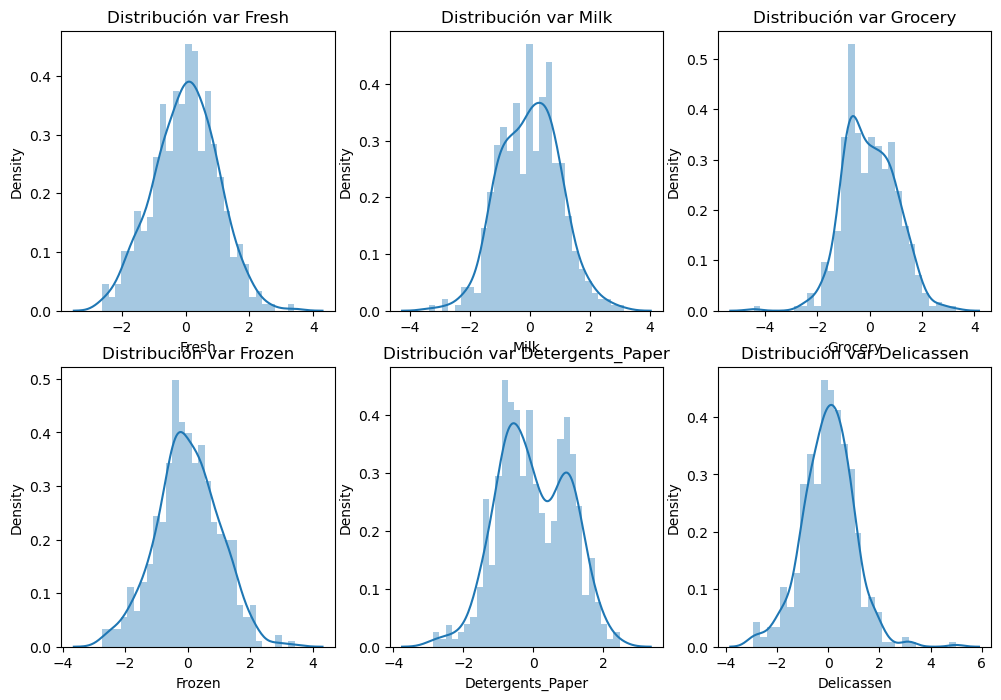

In [83]:
plt.figure(figsize=(12,8))
n = 0
for i, column in enumerate(X_cuants_boxcox.columns):
    n+=1
    plt.subplot(2, 3, n)
    sns.distplot(X_cuants_boxcox[column], bins=30)
    plt.title('Distribución var {}'.format(column))

Las distribuciones ahora si parecen gaussianas

## Tratamiento de outliers:

Otro de los tratamientos que debemos hacer es el de tratar los outliers o valores atípicos.

Text(0.5, 0, 'Nombre de la variable')

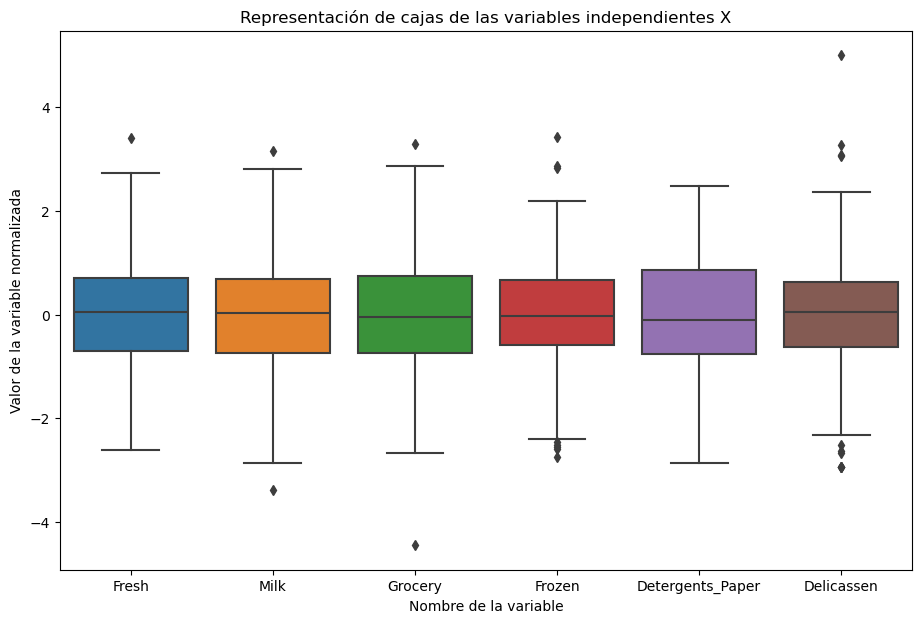

In [84]:
plt.figure(figsize=(11,7))
ax = sns.boxplot(X_cuants_boxcox)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
plt.xlabel('Nombre de la variable')

In [85]:
# Calculamos los cuartiles
Q1 = X_cuants_boxcox.quantile(0.25)
Q3 = X_cuants_boxcox.quantile(0.75)

# Calculamos el rango intercuartílico (IQR)
IQR = Q3 - Q1

# Definimos los límites para los valores atípicos
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Filtrar los valores que están dentro de los límites
X_cuants_filtered = X_cuants_boxcox[~((X_cuants_boxcox < lower) | (X_cuants_boxcox > upper)).any(axis=1)]

Text(0.5, 0, 'Nombre de la variable')

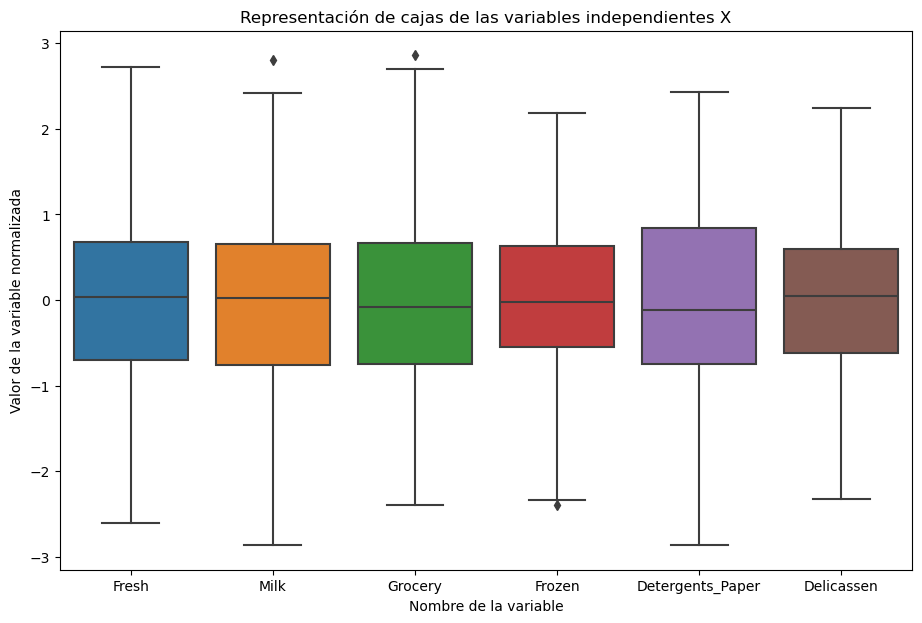

In [86]:
plt.figure(figsize=(11,7))
ax = sns.boxplot(X_cuants_filtered)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
plt.xlabel('Nombre de la variable')

Ahora ya no tengo outliers y las variables están distribuidas de forma normal.

## Creo dummies de las variables categóricas

In [87]:
# En df uno las dos variables categóricas iniciales y las numéricas transformadas
df  =  pd.concat([X[['Channel','Region']],X_cuants_boxcox],axis=1)
df[:3]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,Retail,Other Region,0.412646,0.979303,0.392937,-1.456705,0.617238,0.335779
1,Retail,Other Region,-0.111180,0.995096,0.626729,0.079718,0.748629,0.599877
2,Retail,Other Region,-0.196043,0.887891,0.408738,0.331996,0.790324,2.245295


In [88]:
df = pd.get_dummies(df,columns=['Channel','Region'],drop_first=True)
df[:3]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporto,Region_Other Region
0,0.412646,0.979303,0.392937,-1.456705,0.617238,0.335779,True,False,True
1,-0.111180,0.995096,0.626729,0.079718,0.748629,0.599877,True,False,True
2,-0.196043,0.887891,0.408738,0.331996,0.790324,2.245295,True,False,True


In [91]:
# Convert boolean columns to integers
df['Channel_Retail'] = df['Channel_Retail'].astype(int)
df['Region_Oporto'] = df['Region_Oporto'].astype(int)
df['Region_Other Region'] = df['Region_Other Region'].astype(int)

In [92]:
df[:2]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporto,Region_Other Region
0,0.412646,0.979303,0.392937,-1.456705,0.617238,0.335779,1,0,1
1,-0.111180,0.995096,0.626729,0.079718,0.748629,0.599877,1,0,1


## Escalado previo de los datos:

El proceso de escalar datos es comúnmente utilizado en aprendizaje automático para garantizar que todas las características (variables) tengan la misma escala. Esto es importante en algoritmos que utilizan medidas de distancia, como SVMs, K-NNs o K-means en nuestro caso, ya que un cambio de "1" unidad en una variable numérica tendría la misma importancia independientemente de la variable.

En este caso, como todo son gastos en productos en la misma moneda no sería necesario estrictamente. Sin embargo, al escalar estamos comparando rangos de variables. Es decir, el cliente C es de los que gasta más o de los que gasta menos en un producto.

In [93]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_escalado = scaler.fit_transform(df)
X_escalado = pd.DataFrame(X_escalado,columns=df.columns)
X_escalado.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporto,Region_Other Region
0,0.503006,0.667729,0.625853,0.209882,0.651772,0.412310,1.0,0.0,1.0
1,0.415768,0.670149,0.656101,0.459175,0.676366,0.445609,1.0,0.0,1.0
2,0.401635,0.653724,0.627898,0.500109,0.684170,0.653077,1.0,0.0,1.0
3,0.510520,0.369822,0.554765,0.636671,0.466264,0.446423,0.0,0.0,1.0
4,0.605605,0.580881,0.619646,0.566556,0.604411,0.589224,1.0,0.0,1.0


# Segmentación utilizando un clustering K-means:

En este paso intento obtener el número de grupos óptimo utilizando la regla del codo.

In [94]:
cluster_range = range(1,20)
cluster_wss=[] 
for cluster in cluster_range:
    model = KMeans(cluster)
    model.fit(X_escalado)
    cluster_wss.append(model.inertia_)

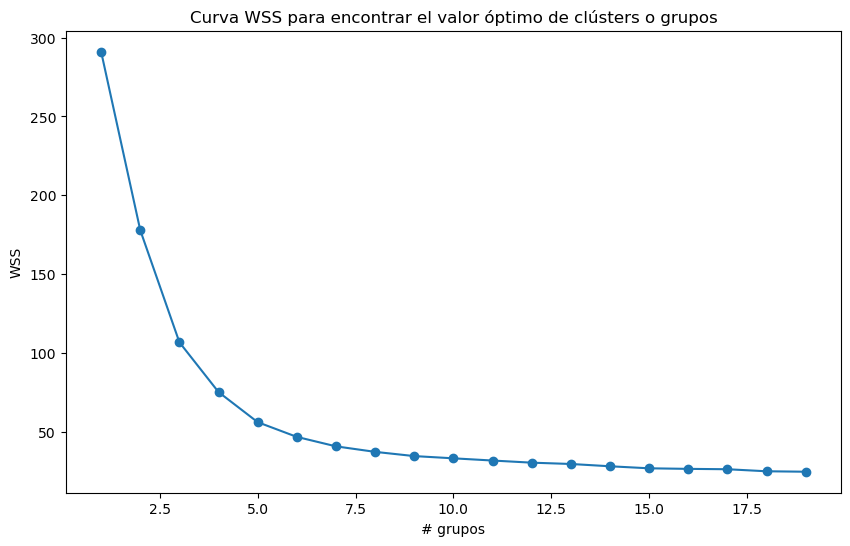

In [95]:
plt.figure(figsize=[10,6])
plt.title('Curva WSS para encontrar el valor óptimo de clústers o grupos')
plt.xlabel('# grupos')
plt.ylabel('WSS')
plt.plot(list(cluster_range),cluster_wss,marker='o')
plt.show()

 El número de clusters en el punto del codo se considera el número óptimo de clusters. Este número representa un equilibrio entre tener suficientes clusters para capturar la estructura subyacente de los datos, pero sin segmentarlos en exceso. Po0r lo tanto, eligiremos 6 grupos

## Utilizo el mejor parámetro k=6:

In [141]:
# Ajusto el modelo con k=6 a los datos
model = KMeans(n_clusters=4,random_state=0)
model.fit(X_escalado)


KMeans(n_clusters=4, random_state=0)

#### Predigo y obtengo clientes con su predicción

In [142]:
# Dataframe con variables originales y la predicción
df_total = X.copy()
df_total['cluster']=model.predict(X_escalado)
df_total[:2]
# Ahora, cada fila de nuestro DataFrame df_total tiene una etiqueta de cluster que indica a qué grupo pertenece según el modelo de K-Means.

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,Retail,Other Region,12669,9656,7561,214,2674,1338,3
1,Retail,Other Region,7057,9810,9568,1762,3293,1776,3


Text(0, 0.5, 'Conteo')

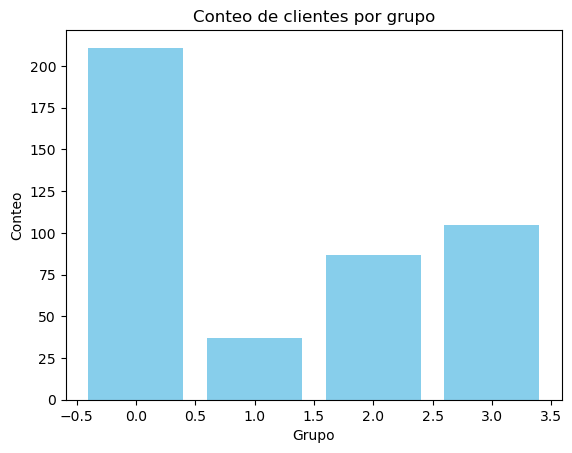

In [143]:
count = df_total.cluster.value_counts()
plt.bar(count.index, count.values, color='skyblue')
plt.title('Conteo de clientes por grupo')
plt.xlabel('Grupo')
plt.ylabel('Conteo')


### Obtengo características de cada grupo:

También obtengo un dataframe con las medias de las variables en cada grupo. Esto representaría cada uno de los grupos.

Esto es muy necesario ya que las acciones que el objetivo de este problema sería hacer acciones a cada uno de los grupos por separado. Para ello es muy importante conocer cómo es cada grupo, de cara a accionar de forma distinta.

In [124]:
# Drop 'Channel' and 'Region' columns, cant do the mean of dummy variables

# Group by 'cluster' and compute the mean
descriptivos_grupos = df_total.groupby('cluster').mean().reset_index()

descriptivos_grupos

,cluster,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,13878.052133,3486.981043,3886.734597,3656.900474,786.682464,1518.284360
1,1,11650.535714,2304.250000,4395.500000,5745.035714,482.714286,1105.892857
2,2,9831.504762,10981.009524,15953.809524,1513.200000,6899.238095,1826.209524
3,3,12902.254237,3870.203390,4026.135593,3127.322034,950.525424,1197.152542
4,4,7289.789474,9190.789474,16326.315789,1540.578947,8410.263158,1239.000000
5,5,5200.000000,10784.000000,18471.944444,2584.111111,8225.277778,1871.944444


In [115]:
df_total.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen', 'cluster'],
      dtype='object')

## Obtenemos una representación de los grupos con PCA:

Antes de aplicar PCA, mis datos tienen un número de dimensiones igual al número de características. Por lo tanto, debemos reducirlo a 2 para poder tener una visualizacion leible y lo conseguimos con el metodo PCA.

In [125]:
pca2 = PCA(n_components=2)
pc = pca2.fit_transform(X_escalado)
pc_df = pd.DataFrame(pc)
pca = pd.concat([pc_df, df_total['cluster']],axis=1)
pca.columns = ['pc1','pc2','cluster']
pca[:2]

,pc1,pc2,cluster
0,0.734510,-0.230644,2
1,0.732991,-0.222444,2


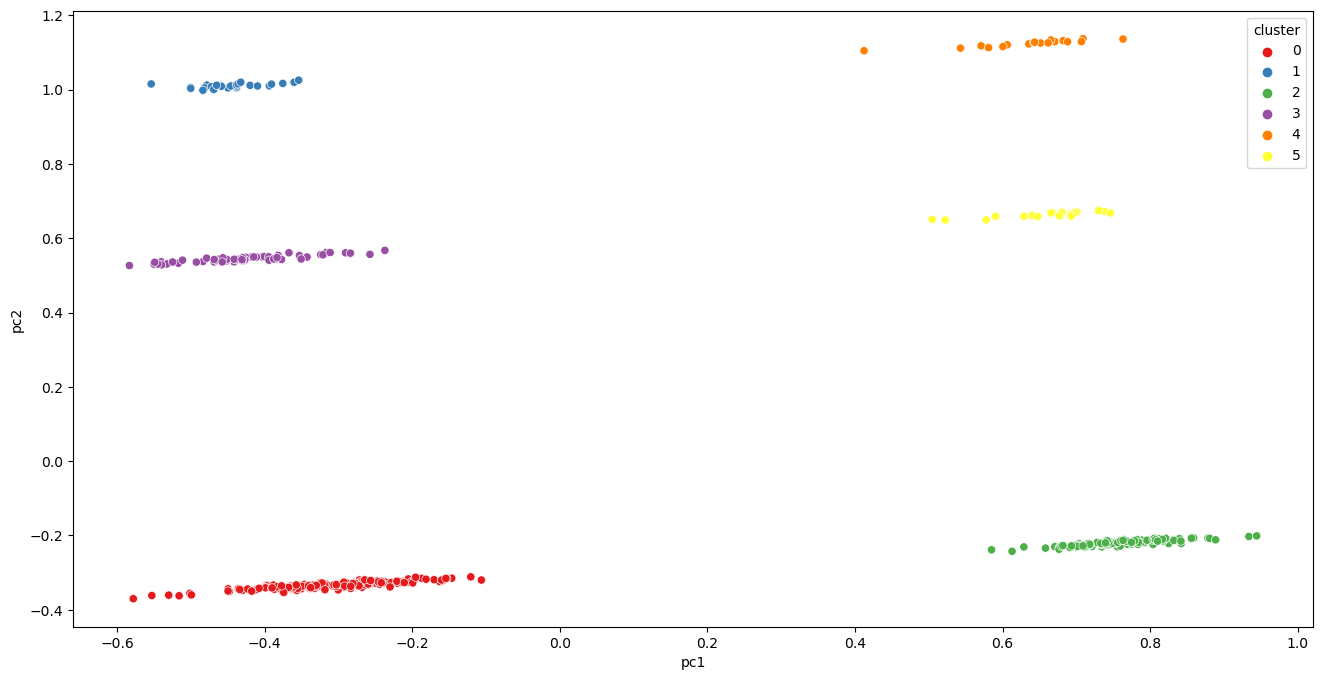

In [126]:
plt.figure(figsize=[16,8])
sns.scatterplot(x='pc1', y='pc2', hue= 'cluster', data=pca, palette='Set1')
plt.show()

Cada punto en el gráfico representa un cliente y su posición está determinada por sus componentes principales, mientras que el color del punto indica a qué cluster pertenece

Las dos componentes principales muestran que los grupos se separan de manera perfecta entre ellos.

## Explico los grupos usando las medias de cada variable por grupo:

Text(0, 0.5, 'Valor medio de gasto')

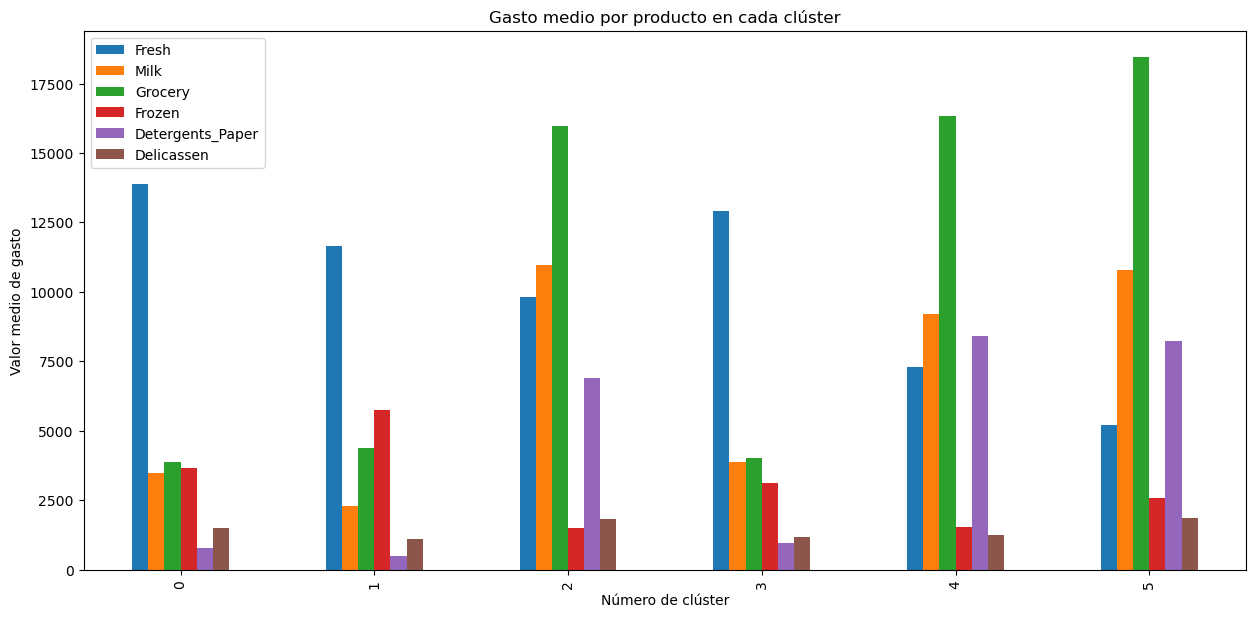

In [137]:
df_total.groupby('cluster').mean().plot(kind='bar', figsize=(15,7))
plt.title('Gasto medio por producto en cada clúster')
plt.xlabel('Número de clúster')
plt.ylabel('Valor medio de gasto')